### Q01: Prepare the environment

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

### Q02: Add Dataset

In [13]:
dataset_path = './realwaste/realwaste-main/RealWaste'

### Q03: Split the dataset into training, validation, and testing

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std for RGB)
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into training and validation datasets
train_size = int(0.6 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Q04: Build the CNN model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, x1, m1, x2, m2, x3, d, K):
        super(CustomCNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, stride=1, padding=m1 // 2)
        self.activation1 = nn.ReLU()  

        # MaxPooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, stride=1, padding=m2 // 2)
        self.activation2 = nn.ReLU()  

        # MaxPooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(x2 * (128 // 4) * (128 // 4), x3)  # Adjust dimensions based on input size and pooling
        self.activation3 = nn.ReLU()  
        self.dropout = nn.Dropout(d)  # Dropout layer

        # Output Layer
        self.fc2 = nn.Linear(x3, K)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer

        x = self.fc1(x)
        x = self.activation3(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Softmax activation

# Define the model parameters
x1, m1 = 32, 3  # Filters and kernel size for the first convolutional layer
x2, m2 = 64, 3  # Filters and kernel size for the second convolutional layer
x3 = 128        # Number of units in the fully connected layer
d = 0.5         # Dropout rate
K = len(dataset.classes)  # Number of output classes

# Instantiate the model
model = CustomCNN(x1, m1, x2, m2, x3, d, K)

# Print the model architecture
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (activation3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


### Check Cuda Availability and Version

In [16]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, check the PyTorch CUDA version
if cuda_available:
    print(f"CUDA version supported by PyTorch: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available in this PyTorch installation.")

CUDA available: False
CUDA is not available in this PyTorch installation.


### Q05: CustomCNN Model Architecture

1. **Conv1 Layer**
- Input Channels: 3 (RGB)
- Output Channels: 32
- Kernel Size: 3x3
- Strid: 1
- Padding: 1 (to maintain spatial dimensions)
- Activation Function: ReLU
- Output Shape after Pooling: (32, 64, 64)

2. **Conv2 Layer**
- Input Channels: 32 (from Conv1)
- Output Channels: 64
- Kernel Size: 3x3
- Stride: 1
- Padding: 1 (to maintain spatial dimensions)
- Activation Function: ReLU
- Output Shape after Pooling: (64, 32, 32)

3. **Flatten Layer**
- Input Shape: (64, 32, 32)
- Output Shape: 65536 features

4. **Fully Connected Layer (fc1)**
- Input Features: 65536
- Output Units: 128
- Activation Function: ReLU

5. **Dropout Layer**
- Dropout Rate: 0.5

6. **Fully Connected Layer (fc2)**
- Input Features: 128
- Output Classes: K (number of output classes)

7. **Softmax Output Layer**
- Output**: Log probabilities over `K` classes

---

#### Number of Parameters Calculation

1. **Conv1 Parameters**:
   - Formula: `(3 * 3 * 3 + 1) * 32`
   - Calculation: `(27 + 1) * 32 = 896`
   
2. **Conv2 Parameters**:
   - Formula: `(32 * 3 * 3 + 1) * 64`
   - Calculation: `(288 + 1) * 64 = 18496`
   
3. **Fully Connected Layer 1 Parameters**:
   - Formula: `(64 * 32 * 32 + 1) * 128`
   - Calculation: `(65536 + 1) * 128 = 8388608`
   
4. **Fully Connected Layer 2 Parameters**:
   - Formula: `(128 + 1) * K`
   - Calculation: `(129) * K`



### Q06:

### ReLU (Rectified Linear Unit)
---
ReLU is chosen as the activation function for intermediate layers due to its efficiency and simplicity. It helps mitigate the **vanishing gradient problem** by maintaining non-zero gradients for positive values, enabling faster and more stable training. Additionally, ReLU introduces **sparsity** in the activations by setting negative values to zero, which:
- Enhances model interpretability.
- Helps reduce overfitting.

From a computational perspective, ReLU is simple and more efficient compared to other nonlinear activation functions like **sigmoid** or **tanh**, making it an ideal choice for deep learning models.

---

### Softmax (used via `log_softmax`)
---
Softmax is applied in the output layer as it converts raw outputs (logits) into a **probability distribution** over \( K \) classes. This is essential for **multi-class classification tasks** where:
- Each output class must have a probability between 0 and 1.
- The predicted probabilities across all classes must sum to 1.

Softmax ensures compatibility with the `CrossEntropyLoss` function, which:
- Directly optimizes the log-probabilities generated by `log_softmax`.
- Ensures proper gradient updates during backpropagation.

By using Softmax, the model can effectively handle classification problems with \( K \) classes.


### Q07: Train the Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, loss function, and optimizer
model = CustomCNN(x1, m1, x2, m2, x3, d, K)  # Define your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
num_epochs = 20  # Number of epochs
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item() * images.size(0)


        # Train Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Calculate Train Accuracy as percentage
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%",
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/20, Train Loss: 1.9558, Train Accuracy: 30.45% Validation Loss: 1.6180, Validation Accuracy: 45.43%
Epoch 2/20, Train Loss: 1.5542, Train Accuracy: 45.25% Validation Loss: 1.3607, Validation Accuracy: 50.58%
Epoch 3/20, Train Loss: 1.3278, Train Accuracy: 52.79% Validation Loss: 1.1691, Validation Accuracy: 60.78%
Epoch 4/20, Train Loss: 1.1367, Train Accuracy: 59.70% Validation Loss: 1.0433, Validation Accuracy: 65.83%
Epoch 5/20, Train Loss: 1.0623, Train Accuracy: 62.50% Validation Loss: 1.0738, Validation Accuracy: 63.09%
Epoch 6/20, Train Loss: 0.9326, Train Accuracy: 65.59% Validation Loss: 1.0294, Validation Accuracy: 64.88%
Epoch 7/20, Train Loss: 0.8514, Train Accuracy: 68.82% Validation Loss: 1.0241, Validation Accuracy: 64.35%
Epoch 8/20, Train Loss: 0.7643, Train Accuracy: 72.04% Validation Loss: 1.0695, Validation Accuracy: 64.88%
Epoch 9/20, Train Loss: 0.7006, Train Accuracy: 74.36% Validation Loss: 1.0989, Validation Accuracy: 62.57%
Epoch 10/20, Train Loss: 0.6

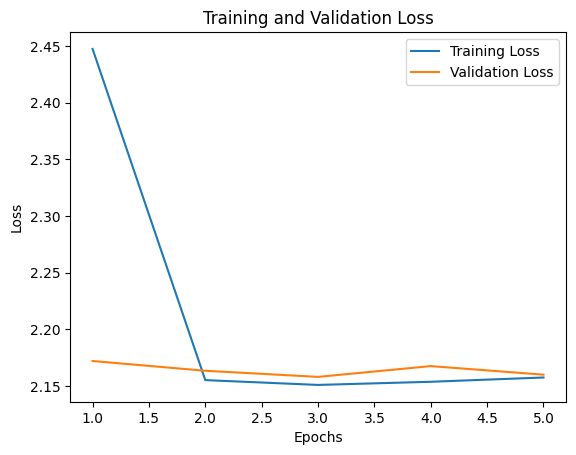

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training and Validation Loss')
plt.show()

### Q08:

The **Adam** optimizer is chosen because it combines the benefits of **Momentum** and **RMSProp**, making it well-suited for deep learning tasks. It dynamically adjusts the learning rate for each parameter using estimates of the **first** and **second moments** of gradients. This enables:
- **Faster convergence**.
- **Better handling of sparse gradients**.

In contrast, **SGD (Stochastic Gradient Descent)** with a fixed learning rate may require more manual tuning and tends to converge slower without additional techniques like **momentum**. 

For tasks like **classification**, where the dataset may have varying complexity, Adam provides better **efficiency** and **performance** out of the box.


### Q09:

**CrossEntropyLoss** is specifically designed for classification problems with **mutually exclusive** classes. It works by comparing the predicted **probability distribution** over classes with the true class labels, penalizing incorrect predictions. This makes it highly suitable for **multi-class classification** tasks like this one.

The loss function's **mathematical formulation** inherently aligns with **softmax outputs**, ensuring proper **gradient updates** for learning discriminative features.


### Q10: Testing the model

Test Loss: 1.4576
Test Accuracy: 66.11%


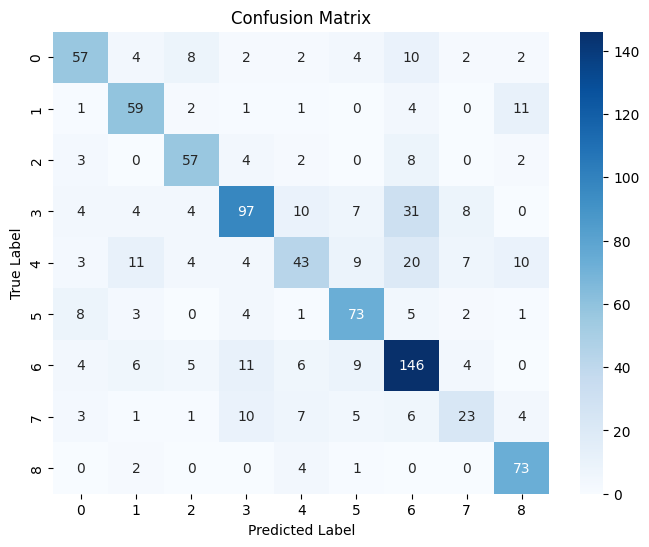

Precision (Weighted): 0.6573
Recall (Weighted): 0.6611
Train Accuracy: 93.30%


In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the testing dataset
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

# Iterate over the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store all labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate Test Accuracy
test_accuracy = 100 * correct / total
test_loss /= len(test_loader.dataset)

# Print test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(K), yticklabels=range(K))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision and Recall
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")

# You can also evaluate train accuracy if needed
model.train()
train_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_accuracy = 100 * correct / total
print(f"Train Accuracy: {train_accuracy:.2f}%")


### Q11: Plot Plot training and validation loss for 0.0001, 0.001, 0.01, and 0.1

--------------------------------
Learning Rate: 0.0001
Epoch 1/5, Train Loss: 1.9749, Train Accuracy: 30.48%  Validation Loss: 1.7168, Validation Accuracy: 42.06%
Epoch 2/5, Train Loss: 1.6980, Train Accuracy: 39.64%  Validation Loss: 1.5176, Validation Accuracy: 49.74%
Epoch 3/5, Train Loss: 1.5481, Train Accuracy: 45.25%  Validation Loss: 1.3809, Validation Accuracy: 51.74%
Epoch 4/5, Train Loss: 1.4511, Train Accuracy: 48.90%  Validation Loss: 1.3435, Validation Accuracy: 52.37%
Epoch 5/5, Train Loss: 1.3245, Train Accuracy: 53.67%  Validation Loss: 1.2194, Validation Accuracy: 58.36%
Testing for Learning Rate: 0.0001
Learning Rate: 0.0001 | Test Loss: 1.2542, Test Accuracy: 54.42%


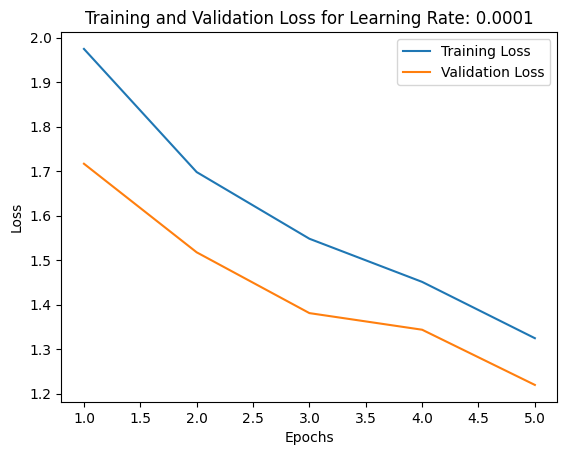

--------------------------------
Learning Rate: 0.001
Epoch 1/5, Train Loss: 1.6315, Train Accuracy: 43.56%  Validation Loss: 1.2623, Validation Accuracy: 56.05%
Epoch 2/5, Train Loss: 1.3063, Train Accuracy: 53.95%  Validation Loss: 1.0942, Validation Accuracy: 60.88%
Epoch 3/5, Train Loss: 1.1386, Train Accuracy: 58.86%  Validation Loss: 1.0430, Validation Accuracy: 61.20%
Epoch 4/5, Train Loss: 1.0115, Train Accuracy: 63.77%  Validation Loss: 1.0672, Validation Accuracy: 62.46%
Epoch 5/5, Train Loss: 0.8911, Train Accuracy: 67.59%  Validation Loss: 1.0454, Validation Accuracy: 65.83%
Testing for Learning Rate: 0.001
Learning Rate: 0.001 | Test Loss: 1.0709, Test Accuracy: 64.11%


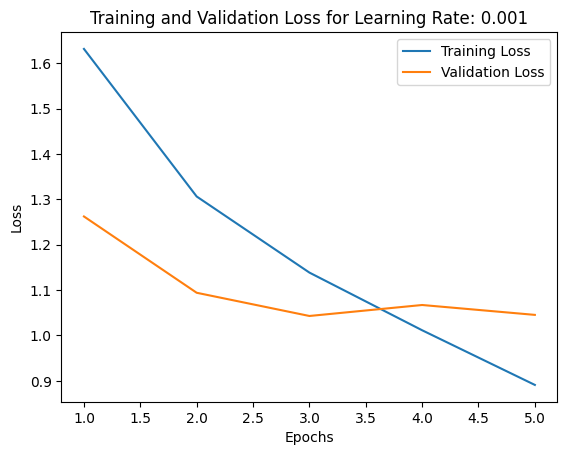

--------------------------------
Learning Rate: 0.01
Epoch 1/5, Train Loss: 2.3240, Train Accuracy: 25.57%  Validation Loss: 1.8492, Validation Accuracy: 34.81%
Epoch 2/5, Train Loss: 1.8567, Train Accuracy: 33.71%  Validation Loss: 1.7286, Validation Accuracy: 39.01%
Epoch 3/5, Train Loss: 1.6697, Train Accuracy: 39.64%  Validation Loss: 1.6980, Validation Accuracy: 37.96%
Epoch 4/5, Train Loss: 1.5853, Train Accuracy: 43.04%  Validation Loss: 1.5994, Validation Accuracy: 43.53%
Epoch 5/5, Train Loss: 1.4856, Train Accuracy: 47.28%  Validation Loss: 1.5491, Validation Accuracy: 42.69%
Testing for Learning Rate: 0.01
Learning Rate: 0.01 | Test Loss: 1.6054, Test Accuracy: 42.11%


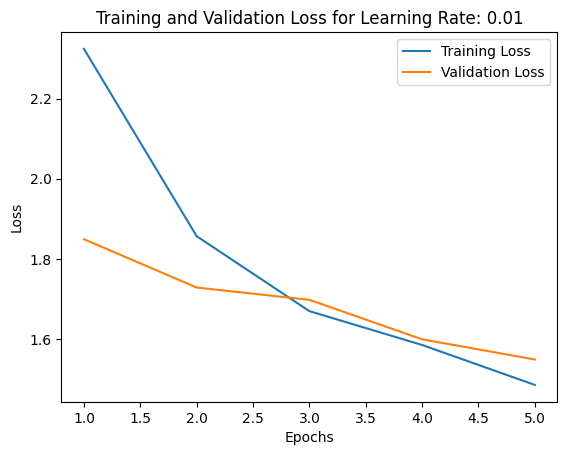

--------------------------------
Learning Rate: 0.1
Epoch 1/5, Train Loss: 2.4473, Train Accuracy: 19.89%  Validation Loss: 2.1720, Validation Accuracy: 18.30%
Epoch 2/5, Train Loss: 2.1552, Train Accuracy: 18.77%  Validation Loss: 2.1634, Validation Accuracy: 18.30%
Epoch 3/5, Train Loss: 2.1509, Train Accuracy: 18.52%  Validation Loss: 2.1580, Validation Accuracy: 18.30%
Epoch 4/5, Train Loss: 2.1537, Train Accuracy: 19.15%  Validation Loss: 2.1675, Validation Accuracy: 16.09%
Epoch 5/5, Train Loss: 2.1575, Train Accuracy: 18.34%  Validation Loss: 2.1600, Validation Accuracy: 16.09%
Testing for Learning Rate: 0.1
Learning Rate: 0.1 | Test Loss: 2.1377, Test Accuracy: 17.37%


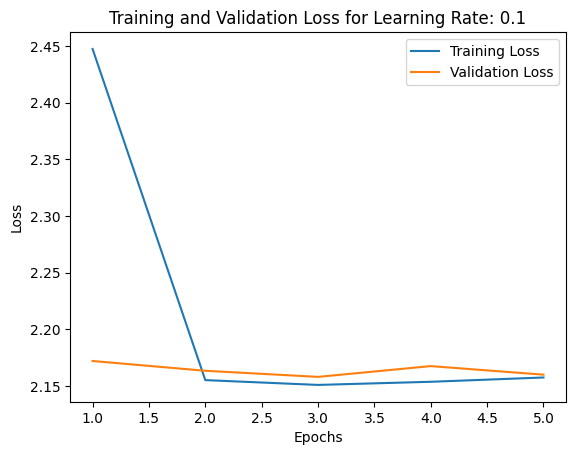

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Model, loss function, and optimizer
model = CustomCNN(x1, m1, x2, m2, x3, d, K)  # Define your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LR = [0.0001, 0.001, 0.01, 0.1]

for lr in LR:
    print("--------------------------------")
    print(f"Learning Rate: {lr}")
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # Training parameters
    num_epochs = 20  # Number of epochs
    train_losses = []
    val_losses = []

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * images.size(0)

            # Train Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Calculate Train Accuracy as percentage
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}% ",
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")
        
    print(f"Testing for Learning Rate: {lr}")
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f"Learning Rate: {lr} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss for Learning Rate: {lr}')
    plt.show()
